# Exploración de datos

## 1. Leyendo datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install jsonlines

In [3]:
import jsonlines
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data_path = '/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/2020_acl_diplomacy/data/'
with jsonlines.open(data_path+'train.jsonl', 'r') as reader:
    train = list(reader)
with jsonlines.open(data_path+'validation.jsonl', 'r') as reader:
    valid = list(reader)
with jsonlines.open(data_path+'test.jsonl', 'r') as reader:
    test = list(reader)

In [5]:
#change the format from list of lists into a single list
def aggregate(dataset):
    '''Función que convierte los datos a formato para entrenamiento

    Se agrega la columna game_ids
    '''
    messages  = []
    rec       = []
    send      = []
    power     = []
    game_ids  = []

    for dialogs in dataset:
        messages.extend(dialogs['messages'])
        rec.extend(dialogs['receiver_labels'])
        send.extend(dialogs['sender_labels'])
        game_id = dialogs['game_id']
        game_ids.extend( [game_id for _ in range(len(dialogs['messages']) )] )

        #ONLY FOR POWER VERSION
        power.extend(dialogs['game_score_delta'])
    #print(len(rec), len(send), len(messages))
    merged = []
    for i, item in enumerate(messages):
        merged.append({'message':item, 'sender_annotation':send[i],
                        'receiver_annotation':rec[i], 'score_delta':int(power[i]),
                        'game_id': game_ids[i]
                        })
    return merged

In [6]:
#only used for getting lie/not lie labels
data_train = aggregate(train)
data_val   = aggregate(valid)
data_test  = aggregate(test)

In [7]:
len(data_train),len(data_val), len(data_test)

(13132, 1416, 2741)

In [8]:
data_train[110]

{'message': "Okay, Italy. I won't share any of this conversation. But in the interest of continued full disclosure, here's what I think: England is a greater threat to *me* on the map, but *you* have a greater chance of soloing this game quickly, or pair-winning with Austria even sooner. And if I continue to collaborate with England, we at least have a chance of slowing that down. So I'm in sort of a conflicted spot",
 'sender_annotation': True,
 'receiver_annotation': True,
 'score_delta': -3,
 'game_id': 1}

## Modificación de conjunto de datos

Para detectar si una frase es verdad o mentira se debe de tener un contexto previo. De tal manera que se modifica el dataset para incluir contexto de los anteriores mensajes.

Esto se realiza ya que en análisis anteriores se observa que muy pocas palabras diferencian a priori la verdad de la mentira

In [9]:
def funcion_agrupacion_mensajes(df,numero_ventana_agrupados=1):

    '''
    Función que agrupa los mensajes para que el algoritmo tenga más contexto
    sobre la decisión de mentira o verdad

    numero_ventana_agrupados: cantidad de mensajes agrupados (además del mismo)

    retorna un dataframe con los datos transformados
    Se disminuye el tamaño del dataframe como  tamaño_original - numero_ventana_agrupados * numero_grupos
    '''

    # lista_mensajes_agrupados        = []
    # lista_nuevo_sender_annotation   = []
    # lista_nuevo_receiver_annotation = []
    # lista_nuevo_game_id             = []

    diccionario_resultados_agrupacion = []

    juegos = df['game_id'].unique()

    #realizando el agrupamiento por juegos realizados
    #Para no mezclar mensajes de juegos diferentes
    for juego in juegos:
        df_filtrado_por_juego = df[df['game_id']==juego]
        cantidad_datos        = df_filtrado_por_juego.shape[0]

        #iterando sobre todo el dataframe filtrado por juego
        for i in range(cantidad_datos- numero_ventana_agrupados):

            #agrupando todos los mensajes
            mensajes_agrupados = ''
            for j in range(0,numero_ventana_agrupados+1):
                (message, sender_annotation,
                receiver_annotation,score_delta,game_id,conjunto)  = df_filtrado_por_juego.iloc[i+j].values
                mensajes_agrupados = mensajes_agrupados + message + '\n\n'

            #print(f"{i}: {mensajes_agrupados}")
            #las etiquetas son los últimos registros de la concatenación
            nuevo_mensaje             = mensajes_agrupados
            nuevo_sender_annotation   = sender_annotation
            nuevo_receiver_annotation = receiver_annotation
            nuevo_game_id             = game_id

            # lista_mensajes_agrupados.append(nuevo_mensaje)
            # lista_nuevo_sender_annotation.append(nuevo_sender_annotation)
            # lista_nuevo_receiver_annotation.append(nuevo_receiver_annotation)
            # lista_nuevo_game_id.append(nuevo_game_id)

            diccionario_resultados_agrupacion.append(
                {'message': nuevo_mensaje, 'sender_annotation':nuevo_sender_annotation,
            'receiver_annotation': nuevo_receiver_annotation, 'game_id':nuevo_game_id}
            )

    return pd.DataFrame(diccionario_resultados_agrupacion)

In [10]:
df_train = pd.DataFrame(data_train)
df_train['set'] = 'train'

df_val   = pd.DataFrame(data_val)
df_val['set'] = 'val'

df_test  = pd.DataFrame(data_test)
df_test['set'] ='test'


numero_ventana_agrupados=3

df_train_agrupado = funcion_agrupacion_mensajes(df_train,numero_ventana_agrupados=numero_ventana_agrupados)
df_val_agrupado   = funcion_agrupacion_mensajes(df_val,numero_ventana_agrupados=numero_ventana_agrupados)
df_test_agrupado  = funcion_agrupacion_mensajes(df_test,numero_ventana_agrupados=numero_ventana_agrupados)


df_train_agrupado['set']  = 'train'
df_val_agrupado['set']    = 'val'
df_test_agrupado['set']   ='test'

In [11]:
df_train_agrupado

,message,sender_annotation,receiver_annotation,game_id,set
0,Germany!\n\nJust the person I want to speak wi...,True,True,1,train
1,"You've whet my appetite, Italy. What's the sug...",True,NOANNOTATION,1,train
2,👍\n\nIt seems like there are a lot of ways tha...,True,NOANNOTATION,1,train
3,It seems like there are a lot of ways that cou...,True,NOANNOTATION,1,train
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,True,1,train
...,...,...,...,...,...
13100,I don’t know. I’m a little annoyed.\n\nI told ...,True,True,10,train
13101,I told Italy about the Lepanto opening and am ...,True,True,10,train
13102,I guess we will see what happens\n\nIs there a...,True,False,10,train
13103,Is there any way of me actually ending this co...,True,True,10,train


In [12]:
df_total = pd.concat([df_train_agrupado,df_val_agrupado,df_test_agrupado])

In [13]:
df_train_agrupado.head(5)

,message,sender_annotation,receiver_annotation,game_id,set
0,Germany!\n\nJust the person I want to speak wi...,True,True,1,train
1,"You've whet my appetite, Italy. What's the sug...",True,NOANNOTATION,1,train
2,👍\n\nIt seems like there are a lot of ways tha...,True,NOANNOTATION,1,train
3,It seems like there are a lot of ways that cou...,True,NOANNOTATION,1,train
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,True,1,train


In [14]:
df_val_agrupado.head(5)

,message,sender_annotation,receiver_annotation,game_id,set
0,"Good afternoon to our friends in the south, ju...",True,True,11,val
1,Of course! I thank you very much. The future o...,True,True,11,val
2,"Well, should the French turn out to be a thorn...",True,True,11,val
3,Greetings from new Italy!\n\nWould just like t...,True,True,11,val
4,Would just like to reiterate that Italy would ...,True,True,11,val


In [15]:
df_test_agrupado.head(5)

,message,sender_annotation,receiver_annotation,game_id,set
0,"Hi Italy! Just opening up communication, and I...",True,True,12,test
1,"Well....that's a great question, and a lot of ...",True,False,12,test
2,"Well, if you want to attack France in the Medi...",True,True,12,test
3,"Hello, I'm just asking about your move to Tyro...",True,True,12,test
4,Totally understandable - but did you notice th...,False,True,12,test


In [16]:
df_train_agrupado['sender_annotation'].value_counts()

True     12516
False      589
Name: sender_annotation, dtype: int64

In [17]:
df_train_agrupado['receiver_annotation'].value_counts()

True            11436
NOANNOTATION     1103
False             566
Name: receiver_annotation, dtype: int64

In [18]:
df_val_agrupado['sender_annotation'].value_counts()

True     1357
False      56
Name: sender_annotation, dtype: int64

In [19]:
df_val_agrupado['receiver_annotation'].value_counts()

True            1233
NOANNOTATION     133
False             47
Name: receiver_annotation, dtype: int64

In [20]:
df_test_agrupado['sender_annotation'].value_counts()

True     2495
False     240
Name: sender_annotation, dtype: int64

In [21]:
df_test_agrupado['receiver_annotation'].value_counts()

True            2308
NOANNOTATION     264
False            163
Name: receiver_annotation, dtype: int64

In [22]:
df_total['sender_annotation'].value_counts()

True     16368
False      885
Name: sender_annotation, dtype: int64

In [23]:
df_total['receiver_annotation'].value_counts()

True            14977
NOANNOTATION     1500
False             776
Name: receiver_annotation, dtype: int64

In [24]:
df_total.shape

(17253, 5)

## 2. Análisis de datos

In [25]:
df_total.head(2)

,message,sender_annotation,receiver_annotation,game_id,set
0,Germany!\n\nJust the person I want to speak wi...,True,True,1,train
1,"You've whet my appetite, Italy. What's the sug...",True,NOANNOTATION,1,train


In [26]:
df_train_agrupado['cantidad_palabras'] = df_train_agrupado['message'].str.split(" ").apply(len)

In [27]:
df_total['cantidad_palabras'] = df_total['message'].str.split(" ").apply(len)

In [28]:
df_total['cantidad_palabras'].describe()

count    17253.000000
mean        78.665507
std         55.956641
min          2.000000
25%         41.000000
50%         64.000000
75%         99.000000
max        587.000000
Name: cantidad_palabras, dtype: float64

In [29]:
df_total[df_total['cantidad_palabras'] > 500]

,message,sender_annotation,receiver_annotation,game_id,set,cantidad_palabras
6506,That’s a good question. \n\nClassicly I suppos...,True,True,3,train,524
8299,"It was a rough turn for both of us, I think. ...",True,NOANNOTATION,6,train,502
10598,But I'm only at 8. I need 4 fleets defending ...,True,True,8,train,542
10599,"So, I need for Russia to be the only one on th...",True,True,8,train,587
12806,two fronted war? Do we maybe want to pin down...,True,NOANNOTATION,10,train,538


Se observa que aunque la cantidad de palabras no es equivalente totalmente a la cantidad de tokens. los mensajes con mayor cantidad de palabras son anotados True o NOANNOTATION lo cual no empeora el desempeño del modelo pues son la clave mayoritaría la que se va a truncar

In [30]:
df_total[ (df_total['cantidad_palabras']) < 5]

,message,sender_annotation,receiver_annotation,game_id,set,cantidad_palabras
2884,What\n\nHow\n\nYeah idk dude\n\nWtf\n\n,True,True,2,train,3
3640,wtf\n\nYeah\n\nHow\n\nHe’s freaked\n\n,True,True,2,train,2
3641,"Yeah\n\nHow\n\nHe’s freaked\n\nYeah, clearly\n\n",True,True,2,train,3
3682,Ok bed now\n\nNight!!!\n\nNight\n\nWelp\n\n,True,True,2,train,3


Se eliminan los mensajes con menos de 5 palabras pues estos no aportan a la detección de mentiras devido a su poco consentido semántico

In [31]:
df_total = df_total[ (df_total['cantidad_palabras']) > 5 ]

In [32]:
df_total[ (df_total['cantidad_palabras']) < 5]

,message,sender_annotation,receiver_annotation,game_id,set,cantidad_palabras


In [33]:
df_total['receiver_annotation'].value_counts()

True            14970
NOANNOTATION     1500
False             776
Name: receiver_annotation, dtype: int64

In [34]:
df_total['receiver_annotation'].value_counts(normalize=True)*100

True            86.802737
NOANNOTATION     8.697669
False            4.499594
Name: receiver_annotation, dtype: float64

## Eliminando registros con NOANNOTATION

se Elimna aproximadamente el 9% de los datos originales

In [35]:
df_total_filtrado = df_total[df_total['receiver_annotation']!='NOANNOTATION']

### Conversión de variable objetivo a números

In [36]:
diccionario_binarizacion_variable_respuesta = {True:1, False:0}

df_total_filtrado['receiver_annotation'] = (df_total_filtrado['receiver_annotation']
                                          .map(diccionario_binarizacion_variable_respuesta))
df_total_filtrado['sender_annotation'] = (df_total_filtrado['sender_annotation']
                                          .map(diccionario_binarizacion_variable_respuesta))

<ipython-input-36-5165e39d8299>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_filtrado['receiver_annotation'] = (df_total_filtrado['receiver_annotation']
<ipython-input-36-5165e39d8299>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_filtrado['sender_annotation'] = (df_total_filtrado['sender_annotation']


In [37]:
df_total_filtrado.head(2)

,message,sender_annotation,receiver_annotation,game_id,set,cantidad_palabras
0,Germany!\n\nJust the person I want to speak wi...,1,1,1,train,121
4,"Yeah, I can’t say I’ve tried it and it works, ...",1,1,1,train,170


### Distribución de registros

<Axes: xlabel='sender_annotation', ylabel='count'>

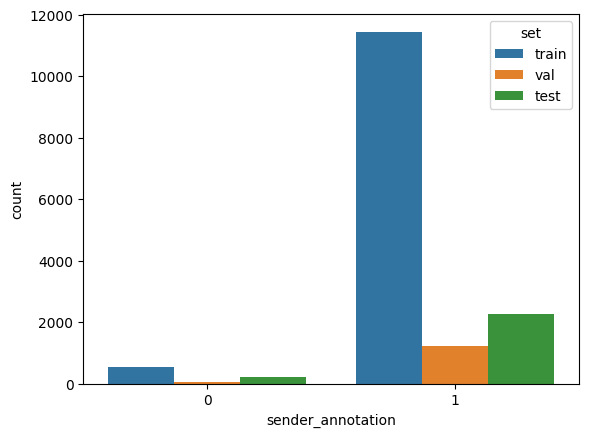

In [38]:

sns.countplot(data=df_total_filtrado,
              x='sender_annotation',hue='set')

<Axes: xlabel='receiver_annotation', ylabel='count'>

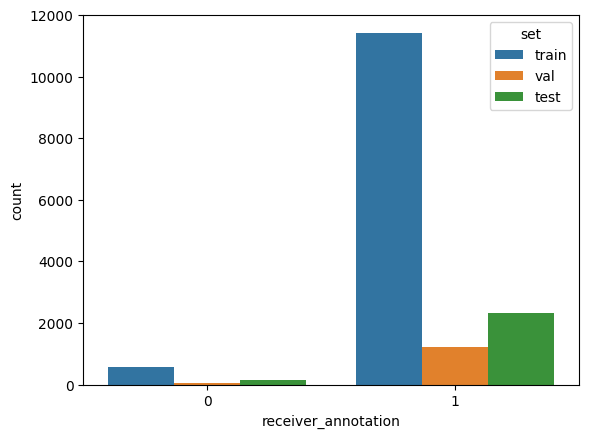

In [39]:
sns.countplot(data=df_total_filtrado,
              x='receiver_annotation',hue='set')

### Verificando distribuciones en cada conjunto de datos



In [40]:
df_total_filtrado.query("set=='train'")['sender_annotation'].value_counts(normalize=True)

1    0.954815
0    0.045185
Name: sender_annotation, dtype: float64

In [41]:
df_total_filtrado.query("set=='val'")['sender_annotation'].value_counts(normalize=True)

1    0.960938
0    0.039062
Name: sender_annotation, dtype: float64

In [42]:
df_total_filtrado.query("set=='test'")['sender_annotation'].value_counts(normalize=True)

1    0.916228
0    0.083772
Name: sender_annotation, dtype: float64

Se observa que para Sender el conjunto de test no sigue la misma distribución en cuanto a proporción a comparación del conjunto de train y validación. Esto  puede ocasionar que las métricas en el conjunto de test no representen de manera correcta el desempeño general del modelo. Posiblemente la separación de datos mediante estratificación no haya sido óptima


In [43]:
df_total_filtrado.query("set=='train'")['receiver_annotation'].value_counts(normalize=True)

1    0.952814
0    0.047186
Name: receiver_annotation, dtype: float64

In [44]:
df_total_filtrado.query("set=='val'")['receiver_annotation'].value_counts(normalize=True)

1    0.963281
0    0.036719
Name: receiver_annotation, dtype: float64

In [45]:
df_total_filtrado.query("set=='test'")['receiver_annotation'].value_counts(normalize=True)

1    0.934035
0    0.065965
Name: receiver_annotation, dtype: float64

Se observa que para Receiver el conjunto de test no sigue la misma distribución en cuanto a proporción a comparación del conjunto de train y validación. Esto  puede ocasionar que las métricas en el conjunto de test no representen de manera correcta el desempeño general del modelo. Posiblemente la separación de datos mediante estratificación no haya sido óptima

### Cantidad de palabras

In [46]:
def statistics(df,column):

    stat_dic = {'mean':df[column].mean(),
                'std':df[column].std(),
                'median':df[column].median()}

    return stat_dic

In [47]:
df_total_filtrado.columns

Index(['message', 'sender_annotation', 'receiver_annotation', 'game_id', 'set',
       'cantidad_palabras'],
      dtype='object')

Text(0.5, 1.0, 'Cantidad de palabras en cada mensaje')

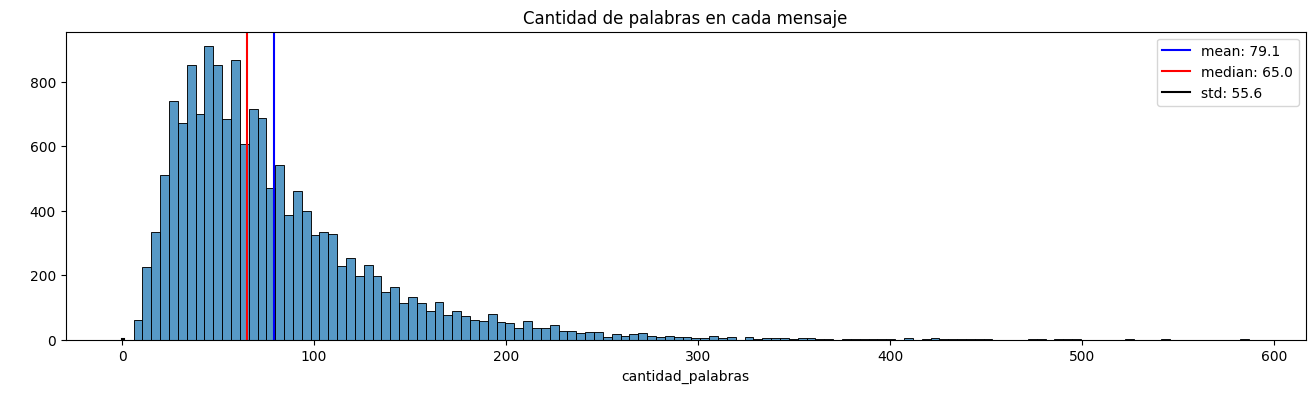

In [48]:
plt.figure(figsize= (16,4))
sns.histplot(data = df_total_filtrado, x = 'cantidad_palabras')
stat_docs = statistics(df_total_filtrado,column='cantidad_palabras')
plt.axvline(stat_docs['mean'], label = 'mean: %.1f' % stat_docs['mean'] , color = 'blue')
plt.axvline(stat_docs['median'], label = 'median: %.1f' % stat_docs['median'] , color = 'red')
plt.plot([1,1], label = 'std: %.1f' % stat_docs['std'] , color = 'black')

plt.legend()
plt.ylabel(" ")
plt.title("Cantidad de palabras en cada mensaje")

In [49]:
df_total_filtrado['cantidad_palabras'].describe()

count    15746.000000
mean        79.075003
std         55.566630
min          6.000000
25%         42.000000
50%         65.000000
75%        100.000000
max        587.000000
Name: cantidad_palabras, dtype: float64

La mayoría mitad de los registros poseen menos de 65 palabras mientras que el registro con mayor cantidad de palabras es 587. sin embargo los mensajes siguen estando en el rango de tokens para el finetune de LLM

In [50]:
df_total_filtrado.columns

Index(['message', 'sender_annotation', 'receiver_annotation', 'game_id', 'set',
       'cantidad_palabras'],
      dtype='object')

Text(0.5, 1.0, 'Cantidad de palabras en cada mensaje')

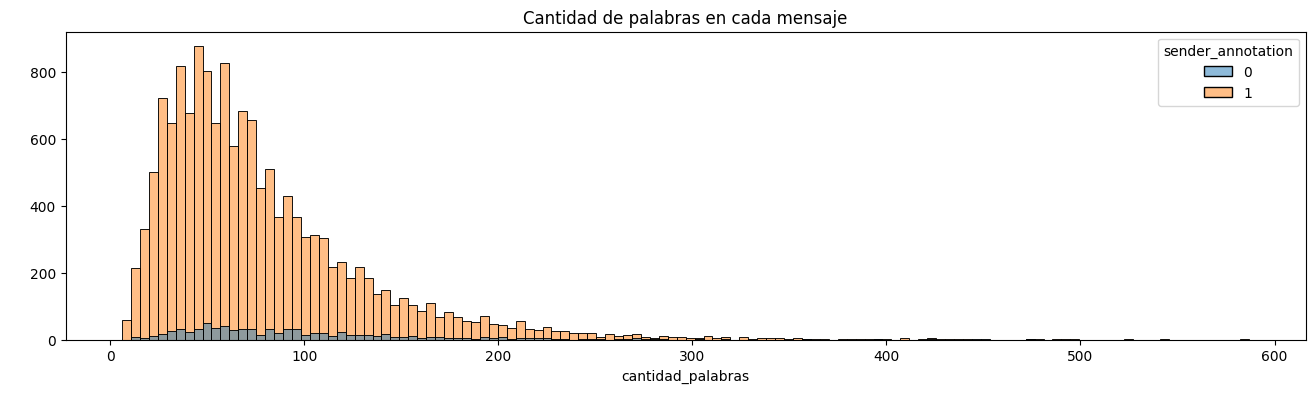

In [51]:
plt.figure(figsize= (16,4))
sns.histplot(data = df_total_filtrado, x = 'cantidad_palabras',hue='sender_annotation')
stat_docs = statistics(df_total_filtrado,column='cantidad_palabras')
# plt.axvline(stat_docs['mean'], label = 'mean: %.1f' % stat_docs['mean'] , color = 'blue')
# plt.axvline(stat_docs['median'], label = 'median: %.1f' % stat_docs['median'] , color = 'red')
# plt.plot([1,1], label = 'std: %.1f' % stat_docs['std'] , color = 'black')

plt.ylabel(" ")
plt.title("Cantidad de palabras en cada mensaje")

<Figure size 1600x400 with 0 Axes>

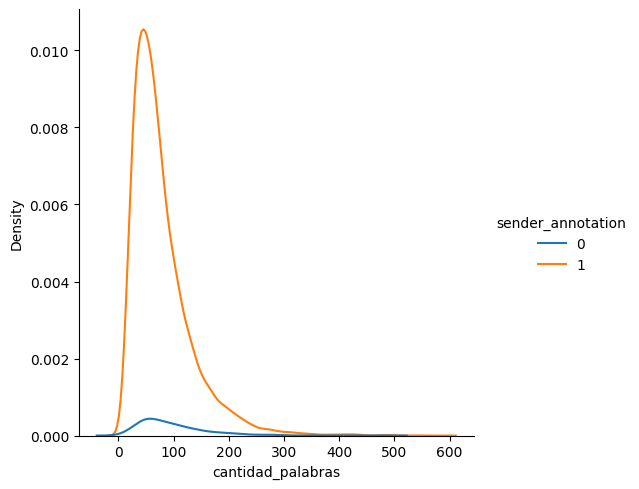

In [52]:
plt.figure(figsize= (16,4))
sns.displot(data = df_total_filtrado, x = 'cantidad_palabras',
            hue='sender_annotation', kind="kde")

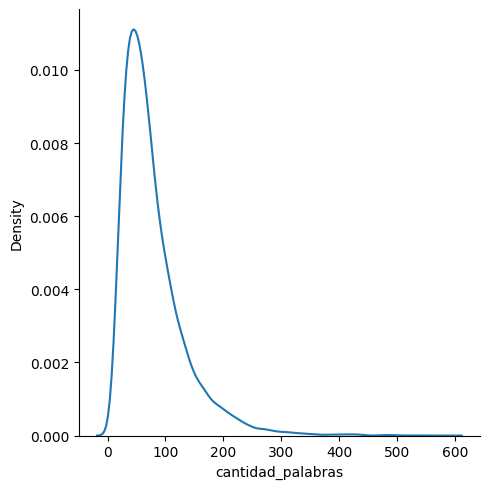

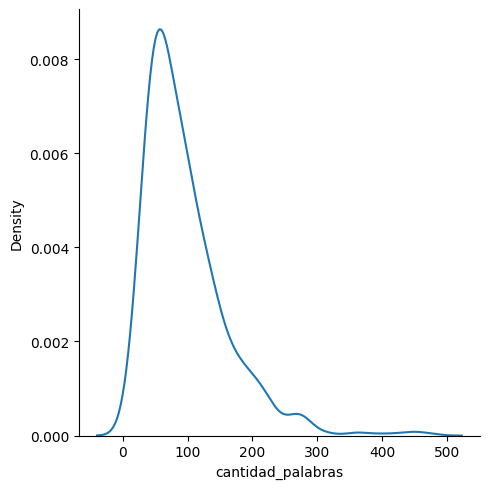

In [53]:
sns.displot(data = df_total_filtrado[df_total_filtrado['sender_annotation']==1],
            x = 'cantidad_palabras', kind="kde")
sns.displot(data = df_total_filtrado[df_total_filtrado['sender_annotation']==0],
            x = 'cantidad_palabras', kind="kde")

Se observa que la distribución de acuerdo a la cantidad de palabras tanto en mentira como en verdad son similares. de tal manera que este atributo no es diferenciador

## Palabras que más frecuentes

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy
from spacy.lang.en import stop_words

In [55]:
nlp = spacy.load('en_core_web_sm')

stop_words = stop_words.STOP_WORDS

In [56]:
len(stop_words)

326

In [57]:
cv = CountVectorizer(stop_words = list(stop_words) )

In [58]:
doc_term_matrix = cv.fit_transform(df_total_filtrado['message'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [59]:
df_count_words = pd.DataFrame(doc_term_matrix.toarray(),
                       columns = cv.get_feature_names_out())

df_count_words.index = df_total_filtrado.index
df_count_words.head()

,01,02,03,05,08,10,100,1000,100000,10pm,...,yyou,zero,zine,zone,zones,zoning,zrussia,zzzzzzzzzzz,знает,хрен
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
df_count_words['receiver_annotation'] = df_total_filtrado['receiver_annotation']
df_count_words['sender_annotation'] = df_total_filtrado['sender_annotation']
df_count_words.head(2)

,01,02,03,05,08,10,100,1000,100000,10pm,...,zine,zone,zones,zoning,zrussia,zzzzzzzzzzz,знает,хрен,receiver_annotation,sender_annotation
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [61]:
 df_total_filtrado['sender_annotation'].value_counts()

1    14947
0      799
Name: sender_annotation, dtype: int64

### 20 palabras más frecuences

In [62]:
num_words = 50
df_count_words.sum(axis=0).sort_values(ascending=False).head(num_words)

receiver_annotation    14970
sender_annotation      14947
think                   6615
france                  6449
russia                  6205
italy                   6003
support                 5663
england                 5629
like                    5385
ll                      5382
austria                 4980
germany                 4846
going                   4780
don                     4723
turkey                  4122
want                    4042
good                    3859
know                    3225
yeah                    3103
sure                    2995
need                    2931
fleet                   2899
turn                    2765
game                    2738
work                    2694
ve                      2674
way                     2652
let                     2632
build                   2581
help                    2563
right                   2341
attack                  2076
north                   1986
moves                   1956
army          

In [63]:
df_sender_true = (
          df_count_words
        .query("sender_annotation==1")
        .sum(axis=0).sort_values(ascending=False)
        .head(num_words)
 )

df_sender_true

sender_annotation      14947
receiver_annotation    14282
think                   6103
france                  6099
russia                  5786
italy                   5724
support                 5343
england                 5240
ll                      5122
like                    5026
austria                 4677
germany                 4543
going                   4483
don                     4396
turkey                  3921
want                    3754
good                    3626
know                    3005
yeah                    2973
sure                    2804
need                    2789
fleet                   2754
turn                    2550
game                    2538
ve                      2492
let                     2480
work                    2473
way                     2451
help                    2403
build                   2402
right                   2190
attack                  1922
north                   1862
moves                   1852
army          

In [64]:
df_sender_false = (
  df_count_words
 .query("sender_annotation==0")
 .sum(axis=0).sort_values(ascending=False)
 .head(num_words)
 )

df_sender_false

receiver_annotation    688
think                  512
russia                 419
england                389
like                   359
france                 350
don                    327
support                320
austria                303
germany                303
going                  297
want                   288
italy                  279
ll                     260
good                   233
work                   221
know                   220
turn                   215
way                    201
turkey                 201
game                   200
sure                   191
ve                     182
build                  179
help                   160
attack                 154
let                    152
right                  151
fleet                  145
need                   142
plan                   132
yeah                   130
alliance               125
north                  124
time                   119
rum                    117
army                   105
t

### Analizando palabras que en común y diferenciadoras

In [65]:
#palabras diferenciadoras:
set(df_sender_true.index) - set(df_sender_false.index)

{'bounce', 'ok', 'sender_annotation', 'trying', 'year', 'yes'}

De las 50 palabras que más se repiten. solo 9 están en verdad y no en mentira. lo que quiere decir que solo por palabras es díficil realizar diferenciaciones entre si está mintiendo o no.

Cabe resaltar las palabras probably y ok pues aunque se pensase que alguien está hablando de manera insegura (probably) sería mentira. en análisis dice que es más frecuence escucharlo en verdad. yes y ok también sugieren que se está diciendo la verdad

In [66]:
#palabras diferenciadoras:
set(df_sender_false.index) - set(df_sender_true.index)

{'centers', 'getting', 'munich', 'pretty', 'rum', 'sorry'}

De las 50 palabras que más se repiten. solo 9 están en mentira y no en verdad. lo que quiere decir que solo por palabras es díficil realizar diferenciaciones entre si está mintiendo o no. Cabe resaltar las palabras sorry, stab, told. pues si se está disculpando (sorry) o si está hablando de otra persona (told) puede ser mentira

In [67]:
from wordcloud import WordCloud

In [68]:
wc = WordCloud(stopwords=stop_words,
               background_color="white",
               colormap="Dark2",
               max_font_size=150,
               random_state=42)

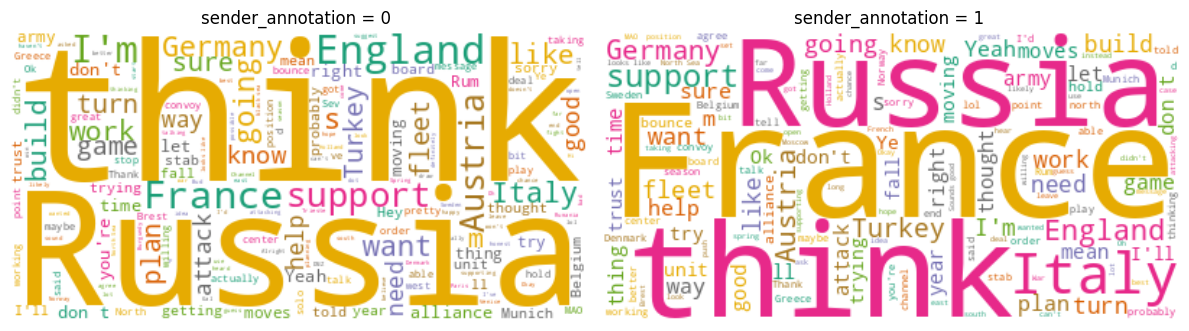

In [69]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axes = plt.subplots(nrows=1, ncols=2)
flat_axes = axes.flat

for index in range(2):
    text_data = df_total_filtrado.query("sender_annotation==@index")['message']
    text = " ".join(riesgo for riesgo in text_data)

    flat_axes[index].imshow(wc.generate(text), interpolation="bilinear")
    flat_axes[index].axis("off")

    flat_axes[index].set_title(f"sender_annotation = {index} ")

fig.tight_layout()
plt.show()

### Se observa que las palabras que más se repiten so los paises del juego

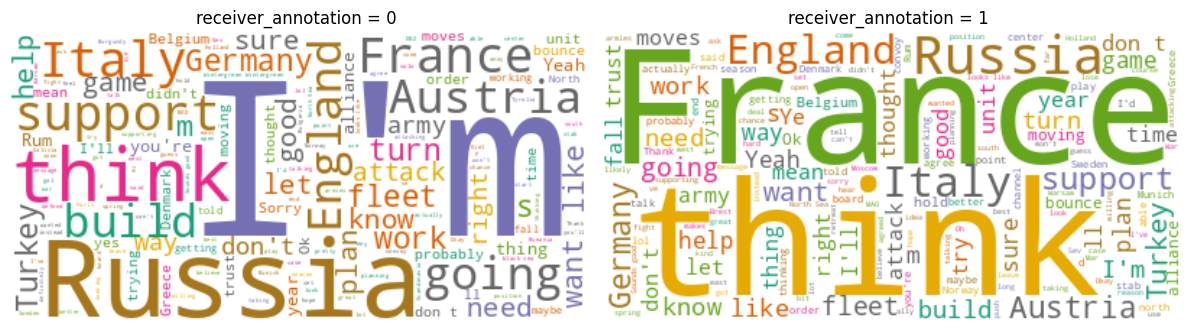

In [70]:
plt.rcParams['figure.figsize'] = [12, 6]
fig, axes = plt.subplots(nrows=1, ncols=2)
flat_axes = axes.flat

for index in range(2):
    text_data = df_total_filtrado.query("receiver_annotation==@index")['message']
    text = " ".join(riesgo for riesgo in text_data)

    flat_axes[index].imshow(wc.generate(text), interpolation="bilinear")
    flat_axes[index].axis("off")

    flat_axes[index].set_title(f"receiver_annotation = {index} ")

fig.tight_layout()
plt.show()

## 3. Limpieza de datos

### Palabras menos frecuentes

In [71]:
df_count_words

,01,02,03,05,08,10,100,1000,100000,10pm,...,zine,zone,zones,zoning,zrussia,zzzzzzzzzzz,знает,хрен,receiver_annotation,sender_annotation
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [72]:
list(df_count_words.columns[:200])

['01',
 '02',
 '03',
 '05',
 '08',
 '10',
 '100',
 '1000',
 '100000',
 '10pm',
 '11',
 '110',
 '11th',
 '12',
 '13',
 '13199396',
 '13hrs',
 '14',
 '15',
 '16',
 '17',
 '18',
 '18th',
 '1901',
 '1902',
 '1903',
 '1904',
 '1905',
 '1906',
 '1907',
 '1908',
 '1909',
 '1910',
 '1914',
 '1a',
 '1b',
 '1st',
 '1v1',
 '20',
 '200',
 '2003',
 '2014',
 '2016',
 '24',
 '25',
 '250',
 '26',
 '2a',
 '2am',
 '2b',
 '2c',
 '2v1',
 '30',
 '30a',
 '30p',
 '3575755',
 '358278238675664896',
 '36',
 '3a',
 '3b',
 '3v2',
 '3x',
 '40',
 '45',
 '4d',
 '4v2',
 '4v3',
 '50',
 '530',
 '5538733581926400',
 '5637073032183808',
 '567829259054219275',
 '5727111032078336',
 '5th',
 '601857887098372112',
 '613143739954888734',
 '61940739',
 '6203125562605568',
 '6340894809128960',
 '730am',
 '730ish',
 '730pm',
 '7449927',
 '7p',
 '8th',
 '94',
 '945',
 '95',
 '99',
 '9pm',
 '_____',
 '_and',
 '_anything_',
 '_us_',
 'aaaaaalllllllllll',
 'aaaaany',
 'aars',
 'aassume',
 'abandon',
 'abandoning',
 'abbreviation',
 

Realizar eliminación de números, caracteres especiales como _:


In [73]:
df_count_words.sum(axis=0).sort_values(ascending=True).head(50)

hiding                1
downvote              1
nicer                 1
parachuted            1
experiencing          1
compliance            1
snack                 1
fills                 1
northeast             1
logjam                1
suddenly              1
correspondence        1
naw                   1
conduct               1
sobered               1
eject                 1
section               1
spoked                1
uniforms              1
kkk                   1
concough              1
endorsed              1
malicious             1
teammate              1
skittish              1
adversary             1
wither                1
arrivederci           1
prohibitive           1
kiss                  1
developed             1
manipulative          1
jetlag                1
601857887098372112    1
jesus                 1
conventionally        1
fu                    1
bye                   1
whet                  1
exposing              1
possibilty            1
greeve          

In [74]:
list(df_count_words.columns[-200:])

['wheel',
 'wheels',
 'whelp',
 'whet',
 'whew',
 'whichever',
 'whild',
 'whipe',
 'whispered',
 'whittling',
 'whoa',
 'wholeheartedly',
 'wholly',
 'whoops',
 'whoppers',
 'whore',
 'whupping',
 'whyever',
 'wick',
 'wide',
 'widely',
 'wierd',
 'wife',
 'wiki',
 'wild',
 'wildcard',
 'willfully',
 'willing',
 'willingly',
 'willingness',
 'win',
 'wind',
 'window',
 'winds',
 'wines',
 'wink',
 'winner',
 'winners',
 'winning',
 'wins',
 'winter',
 'wintergreen',
 'wipe',
 'wiped',
 'wiping',
 'wire',
 'wires',
 'wirh',
 'wise',
 'wisely',
 'wish',
 'wished',
 'wishes',
 'wishful',
 'wishing',
 'wishy',
 'witchcraft',
 'withdraw',
 'withdrawal',
 'withdrawing',
 'withdrew',
 'wither',
 'withholding',
 'withing',
 'witness',
 'witnessed',
 'wizard',
 'wmed',
 'woah',
 'woke',
 'women',
 'womrth',
 'won',
 'wonder',
 'wonderful',
 'wondering',
 'wont',
 'woods',
 'wooo',
 'woooooo',
 'woops',
 'word',
 'worded',
 'wording',
 'words',
 'wordy',
 'work',
 'workable',
 'worked',
 'worki

## Ejecución de limpieza

In [75]:
import re
def limpiar_texto_1(texto):
    #convertiendo a minúsculas

    texto = texto.lower()

    #Eliminamos los caracteres especiales
    texto = re.sub(r'_', ' ', texto)
    texto = re.sub(r'll', ' ', texto)

    #eliminando sitios web
    pattern  = re.compile(r'(htt)\S+')
    texto = re.sub(pattern = pattern, repl= '',string = texto )
    pattern  = re.compile(r'(www)\S+')
    texto = re.sub(pattern = pattern, repl= '',string = texto )

    #Eliminación correos
    pattern = re.compile(r'\S*@\S*\s?')
    texto = re.sub(pattern = pattern, repl= '',string = texto )


    #eliminando números
    pattern  = re.compile(r'\w*\d\w*')
    texto = re.sub(pattern = pattern, repl= '',string = texto )
    pattern  = re.compile(r'\d+')
    texto = re.sub(pattern = pattern, repl= '',string = texto )


    #Sustituir los espacios en blanco en uno solo
    pattern  = re.compile(r'\s+')
    texto  = re.sub(pattern = pattern, repl= ' ',string = texto)

    #Eliminando espacios iniciales y finales
    texto = texto.rstrip().lstrip()
    return texto

#####################################################
#####################################################
#####################################################
#####################################################
#####################################################
#####################################################



def limpiar_datos(tipo_limpieza, df,datos):
    print("2.")
    if tipo_limpieza =='limpieza_1':
        print("limpieza_1 usada")
        return df[datos].apply(limpiar_texto_1)

    elif tipo_limpieza =='no':
        print("no limpieza usada")
        return df[datos]


In [76]:
df_total_filtrado['input'] = limpiar_datos(tipo_limpieza='limpieza_1',
                                           df = df_total_filtrado,
                                           datos = 'message')

2.
limpieza_1 usada


<ipython-input-76-2be8925916e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_filtrado['input'] = limpiar_datos(tipo_limpieza='limpieza_1',


In [77]:
df_total_filtrado.head(2)

,message,sender_annotation,receiver_annotation,game_id,set,cantidad_palabras,input
0,Germany!\n\nJust the person I want to speak wi...,1,1,1,train,121,germany! just the person i want to speak with....
4,"Yeah, I can’t say I’ve tried it and it works, ...",1,1,1,train,170,"yeah, i can’t say i’ve tried it and it works, ..."


In [78]:
cv_clean = CountVectorizer(stop_words = list(stop_words) )

doc_term_matrix_clean = cv_clean.fit_transform(df_total_filtrado['input'])
df_count_words = pd.DataFrame(doc_term_matrix_clean.toarray(),
                       columns = cv_clean.get_feature_names_out())

df_count_words.index = df_total_filtrado.index
df_count_words.head()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


,aaaaaa,aaaaany,aars,aassume,abandon,abandoning,abbreviation,abic,abide,abiding,...,yuuuuup,yyou,zero,zone,zones,zoning,zrussia,zzzzzzzzzzz,знает,хрен
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Entrenamiento de modelo


## 4.1 Conversión de datos


In [79]:
%%capture
!pip install transformers[torch]

In [80]:
%%capture
!pip install datasets

In [81]:
import torch
from datasets import Dataset, DatasetDict

In [82]:
df_total_para_modelo = df_total_filtrado[['input','sender_annotation','set']]

## Submuestreo

Debido al desbalanceo de la clases se realiza submuestreo del conjunto de train y validation con el fin de incentivar más al modelo a predecir la mentira (la clase subrepresentada)

In [83]:
def undersample(df_temp_train,columna, razon_neg_pos=0.1,activate_undersample=True):

    df_temp_train_copy = df_temp_train.copy()
    y_train = df_temp_train_copy[columna].values.reshape(-1,1)
    df_temp_train_copy['id_elemento'] = df_temp_train_copy.index

    #calculando la cantidad de positivos para la razón_neg_pos dada
    diccionario_proporcion = df_temp_train_copy['label'].value_counts().to_dict()
    muestreo = int(diccionario_proporcion[0]/razon_neg_pos)
    print(diccionario_proporcion[0])
    print("muestreo positivos",muestreo )


    if activate_undersample:
        #adjuntando a el df_copy el target para hacer la separación
        df_temp_train_copy['clase'] = y_train.reshape(-1)
        #adjuntando el id del mensaje del para conocer de que mensaje vino

        #separando df en presencia y no presencia de riesgo
        df_temp_train_copy_no_verdad = df_temp_train_copy[df_temp_train_copy['clase'] ==0]
        df_temp_train_copy_si_verdad = df_temp_train_copy[df_temp_train_copy['clase'] ==1]
        cantidad_no_verdad             = df_temp_train_copy_no_verdad.shape[0]
        print("cantidad_no_verdad",cantidad_no_verdad)

        #submuestreando los mensajes verdaderos
        df_temp_train_copy_si_verdad_sampled = df_temp_train_copy_si_verdad.sample(muestreo, random_state = 42)

        #concatenando los registros con si verdad y con no verdad
        df_temp_train_resampled = pd.concat((df_temp_train_copy_no_verdad,df_temp_train_copy_si_verdad_sampled))
        df_temp_train_resampled = df_temp_train_resampled.sample(muestreo+cantidad_no_verdad, random_state = 42)

        print("shape luego de realizar submuestreo ",df_temp_train_resampled.shape)
        print("razon neg/pos", cantidad_no_verdad/muestreo *100 )

        return df_temp_train_resampled.drop('clase',axis=1).drop('id_elemento',axis=1)
    else:
        df_temp_train_resampled = df_temp_train_copy

    return df_temp_train_resampled

In [86]:
df_total_para_modelo.columns= ['text','label','set']

In [87]:
df_train_para_modelo = df_total_para_modelo.query("set=='train'").drop('set',axis=1)
df_val_para_modelo   = df_total_para_modelo.query("set=='val'").drop('set',axis=1)
df_test_para_modelo  = df_total_para_modelo.query("set=='test'").drop('set',axis=1)

In [88]:
razon_neg_pos = 0.3

df_train_para_modelo_submuestreo = undersample(df_temp_train=df_train_para_modelo,
                                               columna='label',
                                               razon_neg_pos=razon_neg_pos,
                                               activate_undersample=True)

df_val_para_modelo_submuestreo = undersample(df_temp_train=df_val_para_modelo,
                                               columna='label',
                                               razon_neg_pos=razon_neg_pos,
                                               activate_undersample=True)

542
muestreo positivos 1806
cantidad_no_verdad 542
shape luego de realizar submuestreo  (2348, 4)
razon neg/pos 30.011074197120706
50
muestreo positivos 166
cantidad_no_verdad 50
shape luego de realizar submuestreo  (216, 4)
razon neg/pos 30.120481927710845


In [89]:
ds = DatasetDict(
      {
      "train": Dataset.from_pandas(df_train_para_modelo_submuestreo.reset_index(drop=True)  ) ,
      "valid": Dataset.from_pandas(df_val_para_modelo_submuestreo.reset_index(drop=True)),
      "test": Dataset.from_pandas(df_total_para_modelo.query("set=='test'").drop('set',axis=1).reset_index(drop=True))
      }
      )

In [90]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 2348
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 216
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2471
    })
})

## Entrenamiento RoBERTa Ironia

In [91]:
from transformers import AutoTokenizer

In [92]:
# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='irony'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
model_ckpt = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [93]:

def tokenize(batch):
  '''
  Función para tokenizar todo el dataset
  padding: Para que en las oraciones que poseen menor
  tamaño que el máximo se les agregue 0's para que todas
  queden del mismo tamaño

  truncation: para que corte los valores mayores a 512 tokesn
  '''
  return tokenizer(batch['text'],
                   padding=True,
                   truncation = True,
                   max_length=512)


In [94]:
ds_encoded = ds.map(tokenize,
                  batched = True,
                  batch_size = None)

Map:   0%|          | 0/2348 [00:00<?, ? examples/s]

Map:   0%|          | 0/216 [00:00<?, ? examples/s]

Map:   0%|          | 0/2471 [00:00<?, ? examples/s]

In [95]:
ds_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2348
    })
    valid: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 216
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2471
    })
})

In [96]:
from transformers import AutoModel,Trainer, TrainingArguments,AutoModelForSequenceClassification

In [97]:
device = torch.device('cuda' if
                      torch.cuda.is_available() else 'cpu')

In [98]:
num_labels = 2

model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels = num_labels)
        .to(device))

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [99]:
from sklearn.metrics import (f1_score,recall_score, precision_score,
                             classification_report,accuracy_score)

In [100]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  #argmax(-1) significa que va a realizar
  #la búsqueda del argumento máximo en el
  #último axis que sale cuando se ejecuta
  #.shape

  f1        = f1_score(labels, preds,average = 'macro')
  recall    = recall_score(labels, preds,average = 'macro')
  precision = precision_score(labels, preds ,average = 'macro')
  acc       = accuracy_score(labels, preds)

  return {'accuracy': acc, 'f1_score': f1,
          'recall':recall, 'precision': precision}

In [101]:
from transformers import Trainer, TrainingArguments

In [102]:
batch_size = 16
logging_steps = len(ds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

logging_steps,model_name

(146, 'cardiffnlp/twitter-roberta-base-irony-finetuned-emotion')

In [103]:
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=5,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  disable_tqdm=False,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='f1_score',
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  logging_strategy="epoch",
                                  save_total_limit=1
                                  )

In [104]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=ds_encoded["train"],
                  eval_dataset=ds_encoded["valid"],
                  tokenizer=tokenizer)

In [105]:
%%time
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.557800,0.524430,0.768519,0.434555,0.500000,0.384259
2,0.505600,0.511211,0.773148,0.489559,0.523976,0.688626
3,0.408300,0.555047,0.750000,0.600985,0.592771,0.624434
4,0.301700,0.617191,0.768519,0.600828,0.590843,0.652632
5,0.202800,0.717342,0.754630,0.597341,0.588795,0.628509


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CPU times: user 17min 59s, sys: 35.9 s, total: 18min 35s
Wall time: 19min 35s


TrainOutput(global_step=735, training_loss=0.3952653430757068, metrics={'train_runtime': 1174.6318, 'train_samples_per_second': 9.995, 'train_steps_per_second': 0.626, 'total_flos': 3088923789926400.0, 'train_loss': 0.3952653430757068, 'epoch': 5.0})

In [106]:
preds_train = trainer.predict(ds_encoded["train"])
preds_valid = trainer.predict(ds_encoded["valid"])
preds_test  = trainer.predict(ds_encoded["test"])

In [107]:
# y_train = df_total_filtrado.query("set=='train'")['sender_annotation'].values
# y_valid = df_total_filtrado.query("set=='val'")['sender_annotation'].values

y_train = df_train_para_modelo_submuestreo['label'].values
y_valid = df_val_para_modelo_submuestreo['label'].values
y_test  = df_total_filtrado.query("set=='test'")['sender_annotation'].values

y_preds_train = np.argmax(preds_train.predictions, axis=1)
y_preds_val   = np.argmax(preds_valid.predictions, axis=1)
y_preds_test  = np.argmax(preds_test.predictions, axis=1)

print(classification_report(y_train,y_preds_train))
print(classification_report(y_valid,y_preds_val))
print(classification_report(y_test,y_preds_test))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       542
           1       0.93      0.93      0.93      1806

    accuracy                           0.90      2348
   macro avg       0.86      0.86      0.86      2348
weighted avg       0.90      0.90      0.90      2348

              precision    recall  f1-score   support

           0       0.44      0.30      0.36        50
           1       0.81      0.89      0.84       166

    accuracy                           0.75       216
   macro avg       0.62      0.59      0.60       216
weighted avg       0.72      0.75      0.73       216

              precision    recall  f1-score   support

           0       0.12      0.16      0.14       207
           1       0.92      0.89      0.90      2264

    accuracy                           0.83      2471
   macro avg       0.52      0.53      0.52      2471
weighted avg       0.85      0.83      0.84      2471



In [108]:
trainer.save_model("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/RoBERTa_irony_4")

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = [
    ]
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='irony'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

In [ ]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [ ]:
text = "Great, it broke the first day..."
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores_1 = output[0][0].detach().numpy()
scores = softmax(scores_1)

In [ ]:
scores, scores_1
#el primer

(array([0.08596174, 0.91403824], dtype=float32),
 array([-1.0298539,  1.3341161], dtype=float32))

In [ ]:
ranking = np.argsort(scores)
ranking

array([0, 1])

In [ ]:
ranking = ranking[::-1]
ranking

array([0, 1])

## EL primero es no ironia, el segundo es ironia

In [ ]:
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")

1) non_irony 0.086
2) irony 0.914


## Modelo RoBERTa + pesos

Como se está enfrentando a un problema de muestras desbalanceadas se agregan pesos a la función de coste para priorizar las predicciones de las mentiras

In [109]:
from torch import nn

In [110]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  #argmax(-1) significa que va a realizar
  #la búsqueda del argumento máximo en el
  #último axis que sale cuando se ejecuta
  #.shape

  f1        = f1_score(labels, preds,average = 'macro')
  recall    = recall_score(labels, preds,average = 'macro')
  precision = precision_score(labels, preds ,average = 'macro')
  acc       = accuracy_score(labels, preds)

  return {'accuracy': acc, 'f1_score': f1,
          'recall':recall, 'precision': precision}

In [111]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        peso_verdad  = 1.0
        peso_mentira = 4.0
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([peso_mentira,peso_verdad], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [112]:
custom_trainer = CustomTrainer(
    model=model,tokenizer=tokenizer,
    args=training_args,
    train_dataset=ds_encoded["train"],
    eval_dataset=ds_encoded["valid"],
    compute_metrics=compute_metrics
)

In [113]:
custom_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Recall,Precision
1,0.391100,1.295215,0.759259,0.608641,0.598795,0.639266
2,0.242200,2.407900,0.763889,0.604977,0.594819,0.645123
3,0.235200,2.555288,0.754630,0.589486,0.581807,0.625207
4,0.174800,3.189969,0.768519,0.563672,0.562892,0.646465
5,0.066400,3.053501,0.750000,0.593589,0.585783,0.620924


TrainOutput(global_step=735, training_loss=0.2219262389098706, metrics={'train_runtime': 1163.4401, 'train_samples_per_second': 10.091, 'train_steps_per_second': 0.632, 'total_flos': 3088923789926400.0, 'train_loss': 0.2219262389098706, 'epoch': 5.0})

In [114]:
preds_train = custom_trainer.predict(ds_encoded["train"])
preds_valid = custom_trainer.predict(ds_encoded["valid"])
preds_test  = custom_trainer.predict(ds_encoded["test"])

In [115]:
y_train = df_train_para_modelo_submuestreo['label'].values
y_valid = df_val_para_modelo_submuestreo['label'].values
y_test  = df_total_filtrado.query("set=='test'")['sender_annotation'].values

y_preds_train = np.argmax(preds_train.predictions, axis=1)
y_preds_val   = np.argmax(preds_valid.predictions, axis=1)
y_preds_test  = np.argmax(preds_test.predictions, axis=1)

print(classification_report(y_train,y_preds_train))
print(classification_report(y_valid,y_preds_val))
print(classification_report(y_test,y_preds_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       542
           1       0.98      0.96      0.97      1806

    accuracy                           0.95      2348
   macro avg       0.93      0.94      0.94      2348
weighted avg       0.96      0.95      0.95      2348

              precision    recall  f1-score   support

           0       0.47      0.30      0.37        50
           1       0.81      0.90      0.85       166

    accuracy                           0.76       216
   macro avg       0.64      0.60      0.61       216
weighted avg       0.73      0.76      0.74       216

              precision    recall  f1-score   support

           0       0.12      0.17      0.14       207
           1       0.92      0.89      0.90      2264

    accuracy                           0.83      2471
   macro avg       0.52      0.53      0.52      2471
weighted avg       0.85      0.83      0.84      2471



In [ ]:
custom_trainer.save_model("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica")

### Conclusiones

Añadir pesos a la función de pérdida no hizo que se incrementara las métricas. al contrario decrecieron.

## GPT-2 SMALL

Probando la clasificación mediante un modelo autoregresivo

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
def creacion_input(mensaje,label):
  map_label = {0:'lie', 1: 'truth'}
  input = f' Message: {mensaje} \n intention: {map_label[label]}'
  return input

def creacion_prompt(mensaje,label):
  map_label = {0:'lie', 1: 'truth'}
  input = f' Message: {mensaje} \n intention: '
  return input

In [ ]:
df_total_para_modelo.columns

Index(['text', 'label', 'set', 'input', 'prompt'], dtype='object')

In [ ]:
df_total_para_modelo['input'] = df_total_para_modelo.apply(lambda x: creacion_input(x.text, x.label) ,
                                          axis = 1 )

<ipython-input-185-9e7e2a1716ce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_para_modelo['input'] = df_total_para_modelo.apply(lambda x: creacion_input(x.text, x.label) ,


In [ ]:
df_total_para_modelo['prompt'] = df_total_para_modelo.apply(lambda x: creacion_prompt(x.text, x.label) ,
                                          axis = 1 )

<ipython-input-186-87c300bc78e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_para_modelo['prompt'] = df_total_para_modelo.apply(lambda x: creacion_prompt(x.text, x.label) ,


In [ ]:
df_total_para_modelo.iloc[0]['input']

' Message: germany! just the person i want to speak with. i have a somewhat crazy idea that i’ve always wanted to try with i/g, but i’ve never actua y convinced the other guy to try it. and, what’s worse, it might make you suspicious of me. so...do i suggest it? i’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? that’s my hope anyway. what is your appetite like for unusual and crazy? \n intention: truth'

In [ ]:
df_train_para_modelo = df_total_para_modelo.query("set=='train'")
df_train_para_modelo

,text,label,set,input,prompt
0,germany! just the person i want to speak with....,1,train,Message: germany! just the person i want to s...,Message: germany! just the person i want to s...
1,"you've whet my appetite, italy. what's the sug...",1,train,"Message: you've whet my appetite, italy. what...","Message: you've whet my appetite, italy. what..."
2,👍,1,train,Message: 👍 \n intention: truth,Message: 👍 \n intention:
3,it seems like there are a lot of ways that cou...,1,train,Message: it seems like there are a lot of way...,Message: it seems like there are a lot of way...
7,"sorry italy i've been away doing, um, german t...",1,train,"Message: sorry italy i've been away doing, um...","Message: sorry italy i've been away doing, um..."
...,...,...,...,...,...
13127,is there any way of me actua y ending this con...,1,train,Message: is there any way of me actua y endin...,Message: is there any way of me actua y endin...
13128,can we agree on peace? what are your demands?,1,train,Message: can we agree on peace? what are your...,Message: can we agree on peace? what are your...
13129,"neutrality in exchange for current holdings, s...",1,train,Message: neutrality in exchange for current h...,Message: neutrality in exchange for current h...
13130,"thats a bit too much, can i keep spain and i h...",1,train,"Message: thats a bit too much, can i keep spa...","Message: thats a bit too much, can i keep spa..."


In [ ]:
df_val_para_modelo  = df_total_para_modelo.query("set=='val'")
df_test_para_modelo = df_total_para_modelo.query("set=='test'")

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler,SequentialSampler
from transformers import AutoTokenizer, AutoModelForCausalLM

In [ ]:
model_name = "gpt2"
# seed
torch.manual_seed(42)

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>', pad_token='<|pad|>')
model = AutoModelForCausalLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) #Importante para que funcione

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [ ]:
batch_size = 8

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=512):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|> '+ txt + ' <|endoftext|>', truncation=True,
                                 max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [ ]:
train_dataset = GPT2Dataset(df_train_para_modelo['input'], tokenizer, max_length=512)
val_dataset   = GPT2Dataset(df_val_para_modelo['input'], tokenizer, max_length=512)

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
training_args = TrainingArguments(output_dir='path_resultados',
                                  num_train_epochs=1,
                                  logging_steps=100,  # Number of update steps between two logs if logging_strategy="steps"
                                  #save_steps=5000,
                                  learning_rate = 5E-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  lr_scheduler_type = 'linear',
                                  warmup_steps = 100,
                                  load_best_model_at_end=True,
                                  save_total_limit=1 , # If a value is passed, will limit the total amount of checkpoints. Deletes the older checkpoints in output_dir.
                                  evaluation_strategy = 'steps',
                                  save_strategy = 'steps',
                                  gradient_accumulation_steps=2)


In [ ]:
# start training
trainer = Trainer(model=model,  args=training_args, train_dataset=train_dataset,
        eval_dataset=val_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                              'attention_mask': torch.stack([f[1] for f in data]),
                                                              'labels': torch.stack([f[0] for f in data])})

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
100,2.191600,0.199461
200,0.217500,0.174000
300,0.206900,0.167647
400,0.203200,0.164989
500,0.208300,0.162793
600,0.196700,0.161728
700,0.202600,0.161051


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=752, training_loss=0.4690008061997434, metrics={'train_runtime': 2441.4939, 'train_samples_per_second': 4.925, 'train_steps_per_second': 0.308, 'total_flos': 3142036684800000.0, 'train_loss': 0.4690008061997434, 'epoch': 1.0})

In [ ]:
trainer.save_model("/content/drive/MyDrive/prueba_tecnica_bancolombia/Prueba practica/modelos/GPT2")

### Evaluación del modelo



In [ ]:
df_val_para_modelo.reset_index(inplace=True, drop=True)

In [ ]:
df_val_para_modelo[df_val_para_modelo['label']==0]

,level_0,index,text,label,set,input,prompt
162,162,163,"neither of us have a good reason to stab you, ...",0,val,Message: neither of us have a good reason to ...,Message: neither of us have a good reason to ...
164,164,165,"i’ do that, it keeps turkey from snagging gre",0,val,"Message: i’ do that, it keeps turkey from sna...","Message: i’ do that, it keeps turkey from sna..."
166,166,167,"so am i, i’d expect they go through me before ...",0,val,"Message: so am i, i’d expect they go through ...","Message: so am i, i’d expect they go through ..."
285,285,304,"i would say trieste, greece to me, and then se...",0,val,"Message: i would say trieste, greece to me, a...","Message: i would say trieste, greece to me, a..."
309,309,333,"on the other hand, i’m not sure i want to atta...",0,val,"Message: on the other hand, i’m not sure i wa...","Message: on the other hand, i’m not sure i wa..."
366,366,404,i also thought i would let you know that i hea...,0,val,Message: i also thought i would let you know ...,Message: i also thought i would let you know ...
367,367,405,so... i guess your new? what do you think abou...,0,val,Message: so... i guess your new? what do you ...,Message: so... i guess your new? what do you ...
383,383,421,"while that might be true, what would you sugge...",0,val,"Message: while that might be true, what would...","Message: while that might be true, what would..."
391,391,429,i am wi ing to concede it to you if you cooper...,0,val,Message: i am wi ing to concede it to you if ...,Message: i am wi ing to concede it to you if ...
392,392,430,"hmm. i messaged austria, and they didn't respo...",0,val,"Message: hmm. i messaged austria, and they di...","Message: hmm. i messaged austria, and they di..."


In [ ]:
model.eval()
index = 1224
prompt_inicial =  df_val_para_modelo.iloc[index]['prompt'] #'the australians? are they landing at galipoli?	 '#df_val_para_modelo.iloc[index]['prompt']
input      = df_val_para_modelo.iloc[index]['input']

prompt = f"<|startoftext|> {prompt_inicial}"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)
longitud  = len(tokenizer.encode(prompt))
sample_outputs = model.generate(
                                generated,
                                do_sample=False,
                                min_length = longitud+2,
                                max_length = longitud + 20,
                                num_return_sequences=1,
                                pad_token_id = tokenizer.eos_token_id
                                )

output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

In [ ]:
print(output)
print("\n")
print(input)


  Message: ok, i didn't think germany would betray me but they did. no matter what situation your in, we have to a start working together to stop germany or they wi win. 
 intention: 
 intention: truth 


 Message: ok, i didn't think germany would betray me but they did. no matter what situation your in, we have to a start working together to stop germany or they wi win. 
 intention: lie


In [ ]:
input.split(" ")[-1]

'lie'

In [ ]:
output.split(" ")[-2]

'truth'

In [ ]:
df_total_para_modelo.shape

(15783, 5)

In [ ]:
diccionario_cambio_string2numero = {'truth':1,'lie':0}
predicciones    = []
valores_reales  = []

for index in range(0, df_val_para_modelo.shape[0]):
  print(index)
  model.eval()
  prompt_inicial =  df_val_para_modelo.iloc[index]['prompt'] #'the australians? are they landing at galipoli?	 '#df_val_para_modelo.iloc[index]['prompt']
  input          = df_val_para_modelo.iloc[index]['input']

  prompt = f"<|startoftext|> {prompt_inicial}"

  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)
  longitud  = len(tokenizer.encode(prompt))
  sample_outputs = model.generate(
                                  generated,
                                  do_sample=False,
                                  min_length = longitud+2,
                                  max_length = longitud + 20,
                                  num_return_sequences=1,
                                  pad_token_id = tokenizer.eos_token_id
                                  )

  output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

  real       = input.split(" ")[-1]
  prediccion = output.split(" ")[-2]

  if prediccion!='truth' and prediccion!='lie':
    print("bad###########", index)
    continue
  else:
    predicciones.append(diccionario_cambio_string2numero[prediccion] )
    valores_reales.append(diccionario_cambio_string2numero[real] )
    print('prediccion:', prediccion, " valor real: ", real)



0
prediccion: truth  valor real:  truth
1
prediccion: truth  valor real:  truth
2
prediccion: truth  valor real:  truth
3
prediccion: truth  valor real:  truth
4
prediccion: truth  valor real:  truth
5
prediccion: truth  valor real:  truth
6
prediccion: truth  valor real:  truth
7
prediccion: truth  valor real:  truth
8
prediccion: truth  valor real:  truth
9
prediccion: truth  valor real:  truth
10
prediccion: truth  valor real:  truth
11
prediccion: truth  valor real:  truth
12
prediccion: truth  valor real:  truth
13
prediccion: truth  valor real:  truth
14
prediccion: truth  valor real:  truth
15
prediccion: truth  valor real:  truth
16
prediccion: truth  valor real:  truth
17
prediccion: truth  valor real:  truth
18
prediccion: truth  valor real:  truth
19
prediccion: truth  valor real:  truth
20
prediccion: truth  valor real:  truth
21
prediccion: truth  valor real:  truth
22
prediccion: truth  valor real:  truth
23
prediccion: truth  valor real:  truth
24
prediccion: truth  valo

In [ ]:
from sklearn.metrics import (classification_report,accuracy_score,
                             f1_score, recall_score, precision_score,
                             jaccard_score)

In [ ]:
print(classification_report(valores_reales,predicciones))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.96      1.00      0.98      1231

    accuracy                           0.96      1281
   macro avg       0.48      0.50      0.49      1281
weighted avg       0.92      0.96      0.94      1281



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
diccionario_cambio_string2numero = {'truth':1,'lie':0}
predicciones    = []
valores_reales  = []

for index in range(0, df_test_para_modelo.shape[0]):
  print(index)
  model.eval()
  prompt_inicial =  df_test_para_modelo.iloc[index]['prompt'] #'the australians? are they landing at galipoli?	 '#df_test_para_modelo.iloc[index]['prompt']
  input          = df_test_para_modelo.iloc[index]['input']

  prompt = f"<|startoftext|> {prompt_inicial}"

  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)
  longitud  = len(tokenizer.encode(prompt))
  sample_outputs = model.generate(
                                  generated,
                                  do_sample=False,
                                  min_length = longitud+2,
                                  max_length = longitud + 20,
                                  num_return_sequences=1,
                                  pad_token_id = tokenizer.eos_token_id
                                  )

  output = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)

  real       = input.split(" ")[-1]
  prediccion = output.split(" ")[-2]

  if prediccion!='truth' and prediccion!='lie':
    print("bad###########", index)
    continue
  else:
    predicciones.append(diccionario_cambio_string2numero[prediccion] )
    valores_reales.append(diccionario_cambio_string2numero[real] )
    print('prediccion:', prediccion, " valor real: ", real)



0
prediccion: truth  valor real:  truth
1
prediccion: truth  valor real:  truth
2
prediccion: truth  valor real:  truth
3
prediccion: truth  valor real:  truth
4
prediccion: truth  valor real:  truth
5
prediccion: truth  valor real:  truth
6
prediccion: truth  valor real:  truth
7
prediccion: truth  valor real:  lie
8
prediccion: truth  valor real:  truth
9
prediccion: truth  valor real:  truth
10
prediccion: truth  valor real:  truth
11
prediccion: truth  valor real:  truth
12
prediccion: truth  valor real:  truth
13
prediccion: truth  valor real:  truth
14
prediccion: truth  valor real:  truth
15
prediccion: truth  valor real:  truth
16
prediccion: truth  valor real:  truth
17
prediccion: truth  valor real:  truth
18
prediccion: truth  valor real:  truth
19
prediccion: truth  valor real:  truth
20
prediccion: truth  valor real:  truth
21
prediccion: truth  valor real:  truth
22
prediccion: truth  valor real:  truth
23
prediccion: truth  valor real:  truth
24
prediccion: truth  valor 

In [ ]:
print(classification_report(valores_reales,predicciones))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       203
           1       0.92      1.00      0.96      2258

    accuracy                           0.92      2461
   macro avg       0.46      0.50      0.48      2461
weighted avg       0.84      0.92      0.88      2461



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
